# 今さら聞けないGANシリーズ(5)

https://qiita.com/triwave33/items/72c7fceea2c6e48c8c07  
WGAN-gpの実装

## Discriminatorのためのモデル定義
discriminator_with_own_lossモデルの実装  
WGAN-gpでは，正解ラベルと予想結果を付き合わせる形式を用いない．  
binary cross entropyなどではなく，損失関数を独自に定義する．  
また，基本的に変更を受けるのはDiscriminatorのみである．

[全体の実装](https://github.com/triwave33/GAN/blob/master/GAN/wgan-gp/wgan_gp_ownloss.py)  
[実装の参考](https://github.com/tjwei/GANotebooks/blob/master/wgan2-keras.ipynb)    

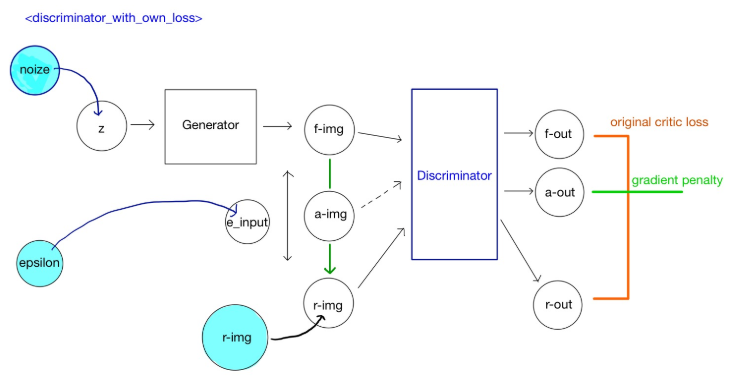

### モデルを作成する  
build_discriminator_with_own_lossはselfのdiscriminatorにWGAN-gpのLossを使わせるようカスタマイズしたモデルを返す  

入力
- z: generatorへの潜在変数 → generatorにより生成データf_imgに変換
- r_img: 本物画像の入力
- e_input: 生成データと本物データの比率 → f_imgとr_imgの間の点a_imgの位置を調整
  
そして，f_img, r_img, a_img → discriminator → f_out, r_out, a_out を得る

### 損失関数を定義する
$$ L_{WGANgp} = \mathbb{E}_{\tilde{x} \sim \mathbb{P}_g} [D(\tilde{x})] - \mathbb{E}_{x \sim \mathbb{P}_r}  [D(x)] + \lambda \mathbb{E}_{\hat{x} \sim \mathbb{P}_{\hat{x}}} [ (||\nabla_{\hat{x}} D(\hat{x})||_2 - 1)^2 ] $$
- 第1項：f_outの平均
- 第2項：r_outの平均
- 第3項：a_outの勾配の2乗平均値から1引いて2乗した値の平均にペナルティ率をかけたもの  

Kを使うことでモデルの一部として扱える

### optimizerをインスタンス化
Adamのget_updatesメソッドによりカスタマイズができる  
- 学習対象の重み → discriminator.trainable_weights
- 学習の際の制約条件 → 空リスト
- 損失関数 → $L_{WGANgp}$

### 入出力とoptimizerインスタンスをfunction化
この新しいdiscriminatorの入力，出力，optimizerをまとめてfunction化する  
これにてdiscriminatorの新たな訓練プログラムを関数として実装できた

### これまでとの相違点
これまでは，
``` python
model = Model(input, output)
↓
model.compile(...)
↓
model.train_on_batch(input, y_true)
```
としていたが，これだと入力と正解ラベルが必ず必要になる．  
ここでは，本物データを入力として与え，Lossを出力として得る．  
それに合わせて，training_updatesとK.functionを用いた形で実装している

### generatorの学習のためのモデル定義
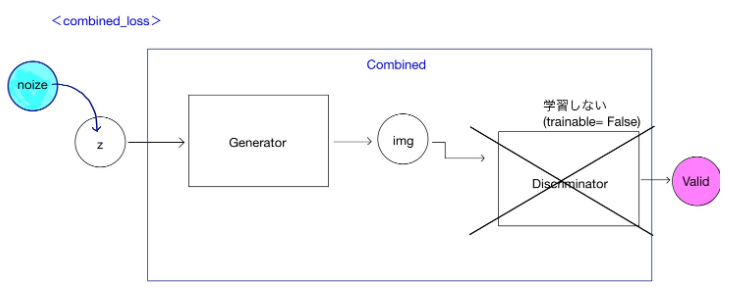
この図に基づき，generator学習のためのcombinedを作る関数build_combined2を実装

### インスタンスの初期化
モデル，関数の初期化の際には学習しない方のtrainableをFalseにして重みを固定

### 全体の学習時
- Discriminator: ノイズ，ピックアップした本物画像，一様分布に従うepsilonを渡してlossを得る  
- Generator: ノイズを渡してlossを得る  

これらのlossをプロット

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Convolution2D
from keras.models import Sequential, Model, load_model
from keras import backend as K
from keras.layers.merge import _Merge
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import sys
import numpy as np
from functools import partial
from utils import sequentially_memory_allocate
sequentially_memory_allocate()

BATCH_SIZE = 32
GRADIENT_PENALTY_WEIGHT = 10
TRAINING_RATIO = 5

class WGAN_GP():
    def __init__(self, latent_dim=5, img_dir="images/wgan_gp/"):
        
        self.path = img_dir
        
        # mnistデータ用の入力データサイズ
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        # 潜在変数の次元数
        self.z_dim = latent_dim
        
        self.n_critic = 5
        
        # 画像保存の際の列，行数
        self.row = 5
        self.col = 5
        self.row2 = 1  # 連続潜在変数用
        self.col2 = 10 # 連続潜在変数用
        
        # 画像生成用の固定された入力潜在変数
        self.noise_fix1 = np.random.normal(0, 1, (self.row * self.col, self.z_dim))
        
        # 連続的に潜在変数を変化させる際の開始，終了変数
        self.noise_fix2 = np.random.normal(0, 1, (1, self.z_dim))
        self.noise_fix3 = np.random.normal(0, 1, (1, self.z_dim))

        # 横軸がiteration数のプロット保存用np.ndarray
        self.g_loss_array = np.array([])
        self.d_loss_array = np.array([])
        self.d_accuracy_array = np.array([])
        self.d_predict_true_num_array = np.array([])
        self.c_predict_class_list = []
        
        
        
        combined_optimizer = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)
        
        # Discriminator
        self.discriminator = self.build_discriminator()
        
        # Generator
        self.generator = self.build_generator()
        
        # combinedの学習時はdiscriminatorを固定
        # おそらくfunctionのところでcompileされる？
        for layer in self.discriminator.layers:
            layer.trainable = False
        self.discriminator.trainable = False
        
        self.netG_model, self.netG_train = self.build_combined()
        
        # discriminatorの学習時には逆にgeneratorを固定
        for layer in self.discriminator.layers:
            layer.trainable = True
        for layer in self.generator.layers:
            layer.trainable = True
        self.discriminator.trainable = True
        self.generator.trainable = False
        
        
        # 生成結果確認用のClassifier
        self.classifier = self.build_classifier()
        
        # Combined
        self.netD_train = self.build_discriminator_with_own_loss()


    # G,Dは基本的にDCGANの実装
    def build_generator(self):

        noise_shape = (self.z_dim,)
        model = Sequential()
        model.add(Dense(1024, input_shape=noise_shape))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dense(128*7*7))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Reshape((7,7,128), input_shape=(128*7*7,)))
        model.add(UpSampling2D((2,2)))
        model.add(Convolution2D(64,5,5,border_mode='same'))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(UpSampling2D((2,2)))
        model.add(Convolution2D(1,5,5,border_mode='same'))
        model.add(Activation('tanh'))
        model.summary()

        return model

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()
        model.add(Convolution2D(64,5,5, subsample=(2,2),\
                  border_mode='same', input_shape=img_shape))
        model.add(LeakyReLU(0.2))
        model.add(Convolution2D(128,5,5,subsample=(2,2)))
        model.add(LeakyReLU(0.2))
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))
        model.add(Dense(1))
        #model.add(Activation('sigmoid'))    #sigmoid関数は使わない
        return model
    
    
    def build_discriminator_with_own_loss(self):
        # 1. モデルの作成
        
        # generatorの入力
        z = Input(shape=(self.z_dim,))
        
        # discriminatorの入力
        f_img = self.generator(z)
        img_shape = (self.img_rows, self.img_cols, self.channels)
        r_img = Input(shape=(img_shape))
        
        # 生成データと偽物のデータの比率を決める値
        # Placeholderにより，train時に設定できる
        e_input = K.placeholder(shape=(None, 1, 1, 1))
        
        a_img = Input(shape=(img_shape), \
                     tensor=e_input * r_img + (1-e_input) * f_img)
        
        # discriminatorの出力
        f_out = self.discriminator(f_img)
        r_out = self.discriminator(r_img)
        a_out = self.discriminator(a_img)
        
        
        
        # 2. 損失関数の作成
        
        # original critic loss
        loss_real = K.mean(r_out) / BATCH_SIZE
        loss_fake = K.mean(f_out) / BATCH_SIZE
        
        # gradient penalty
        grad_mixed = K.gradients(a_out, [a_img])[0]
        norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
        grad_penalty = K.mean(K.square(norm_grad_mixed - 1))
        
        # 最終的な損失関数
        loss = loss_fake - loss_real + GRADIENT_PENALTY_WEIGHT * grad_penalty
        
        
        
        # 3. optimizer をインスタンス化
        training_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)\
            .get_updates(self.discriminator.trainable_weights, [], loss)
        
        
        
        # 4. 入出力とoptimizerをfunction化
        d_train = K.function([r_img, z, e_input], \
                            [loss_real, loss_fake], \
                            training_updates)
        
        return d_train


    def build_combined(self):
        z = Input(shape=(self.z_dim,))
        img = self.generator(z)
        valid = self.discriminator(img)
        model = Model(z, valid)
        model.summary()
        loss = -1. * K.mean(valid) # lossは最小化対象なのでマイナスをつける
        
        training_updates = Adam(lr=1e-4, beta_1=0.5, beta_2=0.9)\
                            .get_updates(self.generator.trainable_weights, [], loss)
        
        g_train = K.function([z], [loss], training_updates)
        
        return model, g_train
    
    
    def build_classifier(self):
        model = load_model("classifier/cnn_model.h5")
        model.load_weights('classifier/cnn_weight.h5')
        return model
    
    
    def train(self, epochs, batch_size=128, save_interval=50):

        # mnistデータの読み込み
        (X_train, _), (_, _) = mnist.load_data()

        #) 値を-1 to 1に規格化
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        #half_batch = int(batch_size / 2)

        self.g_loss_array = np.zeros(epochs)
        self.d_loss_array = np.zeros(epochs)
        self.d_accuracy_array = np.zeros(epochs)
        self.d_predict_true_num_array = np.zeros(epochs)
        # gradient_penalty loss function and is not used.
        positive_y = np.ones((batch_size, 1), dtype=np.float32)
        negative_y = -positive_y
        dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

        for epoch in range(epochs):

            for j in range(TRAINING_RATIO):
    
                # ---------------------
                #  Discriminatorの学習
                # ---------------------
    
                # バッチサイズをGeneratorから生成
                noise = np.random.normal(0, 1, (batch_size, self.z_dim))
                gen_imgs = self.generator.predict(noise)
    
                # バッチサイズを教師データからピックアップ
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]

                epsilon = np.random.uniform(size = (batch_size, 1,1,1))
                errD_real, errD_fake = self.netD_train([imgs, noise, epsilon])
                d_loss = errD_real - errD_fake

    
                # discriminatorを学習
                # 本物データと偽物データは一緒に学習させる
    
                # discriminatorの予測（本物と偽物が半々のミニバッチ）
                d_predict = self.discriminator.predict_classes(np.concatenate([gen_imgs,imgs]), verbose=0)
                d_predict = np.sum(d_predict)

            c_predict = self.classifier.predict_classes(np.concatenate([gen_imgs,imgs]), verbose=0)


            # ---------------------
            #  Generatorの学習
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.z_dim))


            # 生成データの正解ラベルは本物（1） 
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.netG_train([noise])

            # np.ndarrayにloss関数を格納
            self.g_loss_array[epoch] = g_loss[0]
            self.d_loss_array[epoch] = d_loss
            self.d_accuracy_array[epoch] = d_loss
            self.d_predict_true_num_array[epoch] = d_predict
            self.c_predict_class_list.append(c_predict)

            if epoch % save_interval == 0:
                
                # 進捗の表示
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss, g_loss[0]))
                
                # 毎回異なる乱数から画像を生成
                self.save_imgs(self.row, self.col, epoch, '', noise)
                # 毎回同じ値から画像を生成
                self.save_imgs(self.row, self.col, epoch, 'fromFixedValue', self.noise_fix1)
                # 二つの潜在変数の間の遷移画像を生成
                total_images = self.row*self.col
                noise_trans = np.zeros((total_images, self.z_dim))
                for i in range(total_images):
                    t = (i*1.)/((total_images-1)*1.)
                    noise_trans[i,:] = t * self.noise_fix2 + (1-t) * self.noise_fix3
                self.save_imgs(self.row2, self.col2, epoch, 'trans', noise_trans)

                # classifierに生成画像のクラス識別をさせる（10000サンプル）
                noise = np.random.normal(0, 1, (10000, self.z_dim))
                class_res = self.classifier.predict_classes(self.generator.predict(noise), verbose=0)
                # plot histgram
                plt.hist(class_res)
                plt.savefig(self.path + "mnist_hist_%d.png" % epoch)
                plt.ylim(0,2000)
                plt.close()


       
                # 学習結果をプロット
                fig, ax = plt.subplots(4,1, figsize=(8.27,11.69))
                ax[0].plot(self.g_loss_array[:epoch])
                ax[0].set_title("g_loss")
                ax[1].plot(self.d_loss_array[:epoch])
                ax[1].set_title("d_loss")
                ax[2].plot(self.d_accuracy_array[:epoch])
                ax[2].set_title("d_accuracy")
                ax[3].plot(self.d_predict_true_num_array[:epoch])
                ax[3].set_title("d_predict_true_num_array")
                fig.suptitle("epoch: %5d" % epoch)
                fig.savefig(self.path + "training_%d.png" % epoch)
                plt.close()

        # 重みを保存
        self.generator.save_weights(self.path + "generator_%s.h5" % epoch)
        self.discriminator.save_weights(self.path + "discriminator_%s.h5" % epoch)


            

    def save_imgs(self, row, col, epoch, filename, noise):
        # row, col
        # 生成画像を敷き詰めるときの行数、列数
    
        gen_imgs = self.generator.predict(noise)
    
        # 生成画像を0-1に再スケール
        gen_imgs = 0.5 * gen_imgs + 0.5
    
    
        fig, axs = plt.subplots(row, col)
        cnt = 0
        if row == 1:
            for j in range(col):
                axs[j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[j].axis('off')
                cnt += 1
        else:
            for i in range(row):
                for j in range(col):
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1

        #fig.savefig("images/mnist_%s_%d.png" % (filename, epoch))
        fig.suptitle("epoch: %5d" % epoch)
        fig.savefig(self.path + "mnist_%s_%d.png" % (filename, epoch))
        plt.close()

Using TensorFlow backend.


ValueError: Protocol message GPUOptions has no "log_device_placement" field.

In [1]:
import tensorflow.compat.v1 as tf
from keras.backend import tensorflow_backend

config = tf.ConfigProto(gpu_options=tf.GPUOptions(
    # visible_device_list="", # specify GPU
    allow_growth=True
))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]  = "0"

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17054322256035352534
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17570831514077682531
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14258528080956222279
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14545995843549789759
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
gan = WGAN_GP()
gan.train(epochs=30000, batch_size=BATCH_SIZE, save_interval=1000)

/root/gan/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:123: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., strides=(2, 2), padding="same")`
/root/gan/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), strides=(2, 2))`
/root/gan/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), padding="same")`
/root/gan/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (5, 5), padding="same")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1024)              6144      
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 6272)              6428800   
_________________________________________________________________
batch_normalization_5 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
__________

KeyboardInterrupt: 

これにより，ランダムノイズベクトルの次元が5なのにも関わらず，良い感じの画像を生成できた．

続いては，ConditionalGANによって任意の数字を能動的に生成する